In [2]:
import einops

from functools import partial
from itertools import product
import numpy as np
from pathlib import Path
from plotnine import ggplot, geom_point, geom_histogram, geom_line, geom_ribbon, qplot, coord_fixed, aes, facet_wrap, labs
import polars as pl
import torch
from scipy.sparse import coo_array, csr_array
from scipy import linalg
import scipy.sparse.linalg as sparselinalg
from tokengrams import MemmapIndex, InMemoryIndex
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformer_lens import HookedTransformer, HookedTransformerConfig
import zstandard as zstd

In [3]:
torch.cuda.is_available()

True

In [4]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer/tinystories512")
ts_bin_path = 'data/tinystories/train.bin'
index_path = "data/tinystories/ngrams/suffix_tree.idx"

index = MemmapIndex(ts_bin_path, index_path)

In [5]:
epoch = 200
model_path = Path('/media/External01/ngram-checkpoints/4layer_tinystories')

ckpt = torch.load(model_path / f'ckpt{epoch}.pt')

In [6]:

def nanogpt_to_hooked_transformer_config(model_args):
    cfg_dict = {
        "d_model": model_args['n_embed'],
        "n_layers": model_args["n_layer"],
        "d_mlp": model_args["n_embed"] * 4,
        "d_head": model_args["n_embed"] // model_args['n_head'],
        "n_heads": model_args["n_head"],
        "n_ctx": model_args["block_size"],
        "d_vocab": model_args["vocab_size"],
        "tokenizer_name": None,
        "act_fn": 'gelu',
        "attn_only": False,
        "positional_embedding_type": "standard",
        "normalization_type": "LN",
        "original_architecture": 'nanogpt'
    }
    return HookedTransformerConfig(**cfg_dict)


def convert_nanogpt_weights(old_state_dict, cfg: HookedTransformerConfig):
    """For https://github.com/karpathy/nanoGPT
    There are two complications with converting nanogpt models:
    The first is that some state dicts have an unwanted prefix on keys that needs to be removed.
    The second is that the models can be saved with or without bias. By default, there
    is no bias. This function can handle both cases."""
    # Nanogpt models saved after torch.compile() have this unwanted prefix
    # This is a simple way to remove it
    unwanted_prefix = "_orig_mod."
    for k, v in list(old_state_dict.items()):
        if k.startswith(unwanted_prefix):
            old_state_dict[k[len(unwanted_prefix) :]] = old_state_dict.pop(k)

    new_state_dict = {}
    new_state_dict["pos_embed.W_pos"] = old_state_dict["transformer.wpe.weight"]
    new_state_dict["embed.W_E"] = old_state_dict["transformer.wte.weight"]

    new_state_dict["ln_final.w"] = old_state_dict["transformer.ln_f.weight"]
    new_state_dict["ln_final.b"] = torch.zeros_like(old_state_dict["transformer.ln_f.weight"])
    new_state_dict["unembed.W_U"] = old_state_dict["lm_head.weight"].T


    bias = False
    if "transformer.ln_f.bias" in old_state_dict:
        bias = True
        new_state_dict["ln_final.b"] = old_state_dict["transformer.ln_f.bias"]
    else:
         new_state_dict["unembed.b_U"] = torch.zeros(cfg.d_vocab, dtype=cfg.dtype)

    for layer in range(cfg.n_layers):
        layer_key = f"transformer.h.{layer}"

        new_state_dict[f"blocks.{layer}.ln1.w"] = old_state_dict[f"{layer_key}.ln_1.weight"]
        # A bias of zeros is required for folding layer norm
        new_state_dict[f"blocks.{layer}.ln1.b"] = torch.zeros_like(
            old_state_dict[f"{layer_key}.ln_1.weight"]
        )
        new_state_dict[f"blocks.{layer}.ln2.w"] = old_state_dict[f"{layer_key}.ln_2.weight"]
        new_state_dict[f"blocks.{layer}.ln2.b"] = torch.zeros_like(
            old_state_dict[f"{layer_key}.ln_2.weight"]
        )

        new_state_dict[f'blocks.{layer}.attn.mask'] = torch.tril(
            torch.ones((cfg.n_ctx, cfg.n_ctx)).bool()
        )
        new_state_dict[f'blocks.{layer}.attn.IGNORE'] = torch.tensor(-torch.inf)

        W = old_state_dict[f"{layer_key}.attn.c_attn.weight"]
        W_Q, W_K, W_V = torch.tensor_split(W, 3, dim=0)
        W_Q = einops.rearrange(W_Q, "(i h) m->i m h", i=cfg.n_heads)
        W_K = einops.rearrange(W_K, "(i h) m->i m h", i=cfg.n_heads)
        W_V = einops.rearrange(W_V, "(i h) m->i m h", i=cfg.n_heads)
        new_state_dict[f"blocks.{layer}.attn.W_Q"] = W_Q
        new_state_dict[f"blocks.{layer}.attn.W_K"] = W_K
        new_state_dict[f"blocks.{layer}.attn.W_V"] = W_V

        W_O = old_state_dict[f"{layer_key}.attn.c_proj.weight"]
        W_O = einops.rearrange(W_O, "m (i h)->i h m", i=cfg.n_heads)
        new_state_dict[f"blocks.{layer}.attn.W_O"] = W_O

        new_state_dict[f"blocks.{layer}.mlp.W_in"] = old_state_dict[
            f"{layer_key}.mlp.c_fc.weight"
        ].T
        new_state_dict[f"blocks.{layer}.mlp.W_out"] = old_state_dict[
            f"{layer_key}.mlp.c_proj.weight"
        ].T

        if bias:
            new_state_dict[f"blocks.{layer}.ln1.b"] = old_state_dict[f"{layer_key}.ln_1.bias"]
            new_state_dict[f"blocks.{layer}.ln2.b"] = old_state_dict[f"{layer_key}.ln_2.bias"]
            new_state_dict[f"blocks.{layer}.mlp.b_in"] = old_state_dict[
                f"{layer_key}.mlp.c_fc.bias"
            ]
            new_state_dict[f"blocks.{layer}.mlp.b_out"] = old_state_dict[
                f"{layer_key}.mlp.c_proj.bias"
            ]

            B = old_state_dict[f"{layer_key}.attn.c_attn.bias"]
            B_Q, B_K, B_V = torch.tensor_split(B, 3, dim=0)
            B_Q = einops.rearrange(B_Q, "(i h)->i h", i=cfg.n_heads)
            B_K = einops.rearrange(B_K, "(i h)->i h", i=cfg.n_heads)
            B_V = einops.rearrange(B_V, "(i h)->i h", i=cfg.n_heads)
            new_state_dict[f"blocks.{layer}.attn.b_Q"] = B_Q
            new_state_dict[f"blocks.{layer}.attn.b_K"] = B_K
            new_state_dict[f"blocks.{layer}.attn.b_V"] = B_V
            new_state_dict[f"blocks.{layer}.attn.b_O"] = old_state_dict[
                f"{layer_key}.attn.c_proj.bias"
            ]
        else:
            new_state_dict[f"blocks.{layer}.mlp.b_out"] = torch.zeros(cfg.d_model, dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.mlp.b_in"] = torch.zeros(cfg.d_mlp, dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.attn.b_Q"] = torch.zeros(
                (cfg.n_heads, cfg.d_head), dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.attn.b_K"] = torch.zeros(
                cfg.n_heads, cfg.d_head, dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.attn.b_V"] = torch.zeros(
                cfg.n_heads, cfg.d_head, dtype=cfg.dtype)
            new_state_dict[f"blocks.{layer}.attn.b_O"] = torch.zeros(cfg.d_model, dtype=cfg.dtype)
            
    return new_state_dict

config = nanogpt_to_hooked_transformer_config(ckpt['model_args'])

In [7]:
from ngram_markov.model import GPT, GPTConfig
from torch.nn.functional import softmax


def check_similarity_with_hf_model(tl_model, gpt_model, tokens, atol):
    tl_logits = tl_model(tokens)
    gpt_logits, _ = gpt_model(tokens)
    assert torch.allclose(softmax(tl_logits, dim=-1), softmax(gpt_logits, dim=-1), atol=atol)

tl_weights = convert_nanogpt_weights(ckpt['model'], config)
tl_model = HookedTransformer(config)
tl_model.load_state_dict(tl_weights)

#gpt_config = GPTConfig(**ckpt['model_args'])

#gpt_model = GPT(gpt_config)
#gpt_model.load_state_dict(ckpt['model'])
#gpt_model.to('cuda')

<All keys matched successfully>

In [8]:
from ngram_markov.utils import create_ngrams

In [182]:
ngram_seed = [0]
rw_n = 2


In [183]:
random_walks = index.batch_sample(ngram_seed, n=rw_n, k=200, num_samples=200)

In [184]:
import collections
from itertools import islice

def sliding_window(iterable, n):
    "Collect data into overlapping fixed-length chunks or blocks."
    # sliding_window('ABCDEFG', 4) → ABCD BCDE CDEF DEFG
    iterator = iter(iterable)
    window = collections.deque(islice(iterator, n - 1), maxlen=n)
    for x in iterator:
        window.append(x)
        yield tuple(window)


In [185]:
from collections import defaultdict

def seq_to_debruijn(rw, n):
    return [ngram for ngram in sliding_window(rw, n)]

ngram_walks = [seq_to_debruijn(rw, rw_n) for rw in random_walks]


In [186]:
import rustworkx as rx
import numpy as np
from typing import List, Tuple
from collections import defaultdict


class NgramNode:

    def __init__(self, ngram: Tuple[int]):
        self.ngram = ngram

    def __repr__(self):
        return self.ngram.__repr__()

def create_weighted_debruijn_subgraph(ngram_walks: List[List[Tuple[int]]], index) -> rx.PyDiGraph:
    # Step 1: Create a set of unique 3-grams (nodes)
    unique_ngrams = set()
    for walk in ngram_walks:
        unique_ngrams.update(walk)
    unique_ngrams = list(unique_ngrams)
    
    # Step 2: Create a dictionary to map n-grams to node indices
    ngram_to_index = {ngram: i for i, ngram in enumerate(unique_ngrams)}
    
    # Step 3: Create dictionaries for prefix and suffix matching
    prefix_dict = defaultdict(set)
    suffix_dict = defaultdict(set)
    for ngram in unique_ngrams:
        prefix = ngram[:-1]
        suffix = ngram[1:]
        prefix_dict[prefix].add(ngram)
        suffix_dict[suffix].add(ngram)
    
    # Step 4: Calculate n-gram transition probabilities
    ngram_dist = np.array(index.batch_count_next(list(unique_ngrams), 511), dtype=np.float32)
    ngram_dist /= ngram_dist.sum(axis=1)[:, None]
    
    # Step 5: Create all possible edges with weights
    weighted_edges = []
    for ngram in unique_ngrams:
        suffix = ngram[1:]
        source = ngram_to_index[ngram]
        for next_ngram in prefix_dict[suffix]:
            target = ngram_to_index[next_ngram]
            weight = ngram_dist[source, next_ngram[-1]]
            if weight > 0:
                weighted_edges.append((source, target, weight))
    
    # Step 6: Build the rustworkx graph
    graph = rx.PyDiGraph(multigraph=False)
    graph.add_nodes_from([NgramNode(gram) for gram in unique_ngrams])
    graph.add_edges_from(weighted_edges)
    
    return graph, ngram_to_index

# Usage
graph, ngram_to_index = create_weighted_debruijn_subgraph(ngram_walks, index)

# Print some basic information about the subgraph
print(f"Number of nodes: {graph.num_nodes()}")
print(f"Number of edges: {graph.num_edges()}")

# Function to get the original 3-gram for a given node index
index_to_ngram = {i: ngram for ngram, i in ngram_to_index.items()}

# Print some example edges with weights to verify
print("\nSample edges with weights:")
for edge in list(graph.weighted_edge_list())[:5]:  # Print first 5 edges
    source_ngram = index_to_ngram[edge[0]]
    target_ngram = index_to_ngram[edge[1]]
    weight = edge[2]
    print(f"{source_ngram} -> {target_ngram} (weight: {weight:.4f})")

Number of nodes: 8059
Number of edges: 219328

Sample edges with weights:
(412, 322) -> (322, 65) (weight: 0.0896)
(412, 322) -> (322, 71) (weight: 0.0593)
(412, 322) -> (322, 324) (weight: 0.1707)
(412, 322) -> (322, 86) (weight: 0.1342)
(412, 322) -> (322, 70) (weight: 0.0041)


In [187]:
from scipy.stats import entropy

def get_node_data(G, node_idx):
    in_weights = np.array([w for _, _, w in G.in_edges(node_idx)])
    out_weights = np.array([w for _, _, w in G.out_edges(node_idx)])
    in_entropy = entropy(in_weights / in_weights.sum())
    out_entropy = entropy(out_weights / out_weights.sum())
    return {
        'node_idx': node_idx,
        'ngram': G[node_idx].ngram,
        'in_weights': in_weights.tolist(),
        'out_weights': out_weights.tolist(),
        'in_degree': G.in_degree(node_idx),
        'out_degree': G.out_degree(node_idx),
        'mean_in_weight': in_weights.mean(),
        'mean_out_weight': out_weights.mean(),
        'in_weight_entropy': in_entropy,
        'out_weight_entropy': out_entropy
    }
    
    



In [188]:
scc = rx.strongly_connected_components(graph)
scc_idx = -1
scc_len = -1
for i, cc in enumerate(scc):
    if len(cc) > 1:
        if len(cc) > scc_len:
            scc_idx = i
            scc_len = len(cc)
        print(f'{i} {len(cc)}')
connected_subgraph = graph.subgraph(scc[scc_idx], preserve_attrs=True)


27 8017


In [189]:
all_node_data = [get_node_data(connected_subgraph, node) for node in connected_subgraph.node_indices()]
node_df = pl.DataFrame(all_node_data)

/home/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


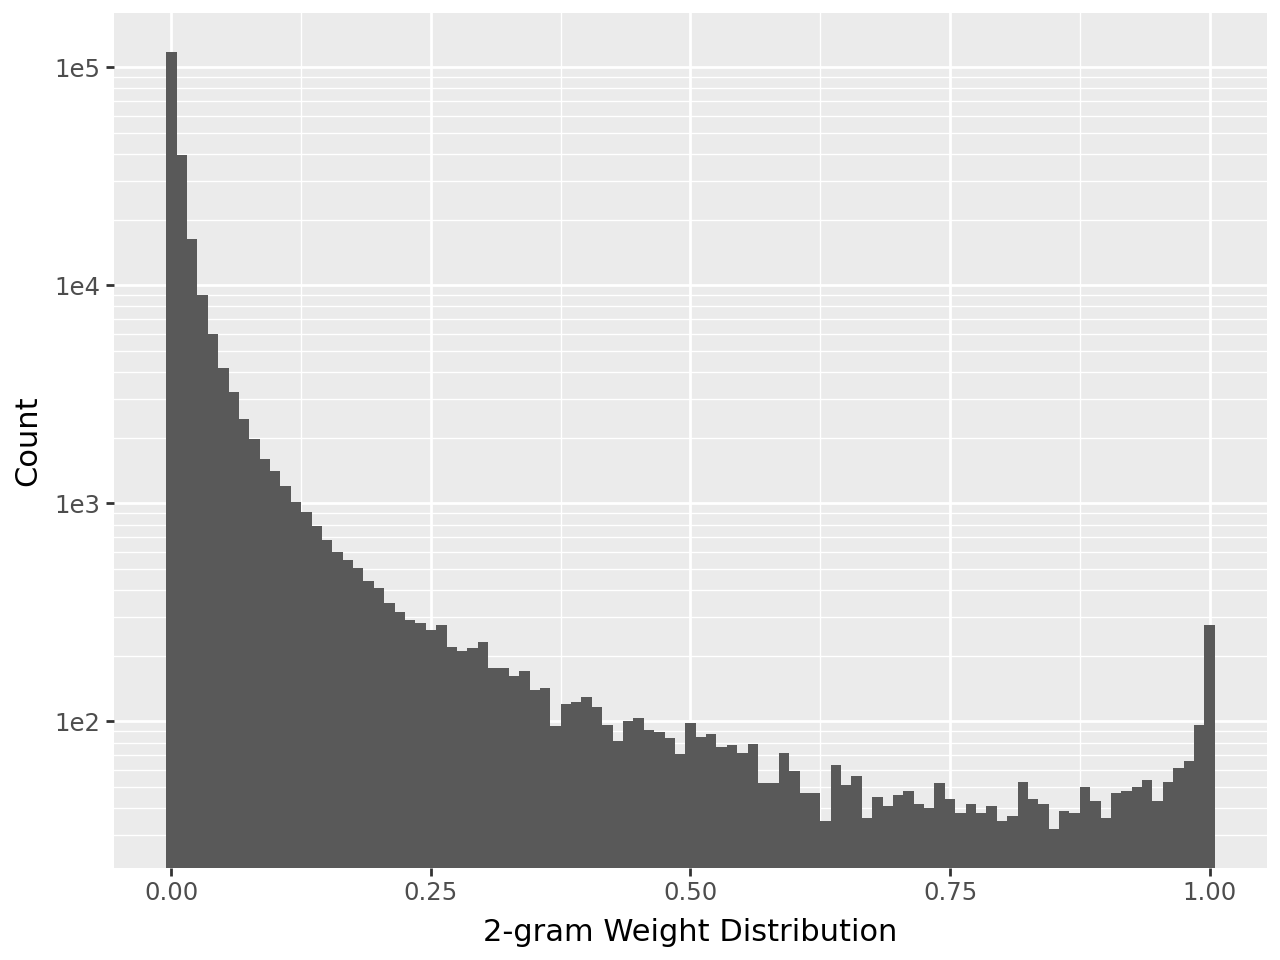

In [190]:
df = node_df.select(pl.col('in_weights')).explode('in_weights')

ggplot(df, aes(x='in_weights')) + geom_histogram(binwidth=0.01) + labs(x=f'{rw_n}-gram Weight Distribution', y='Count') + scale_y_log10()

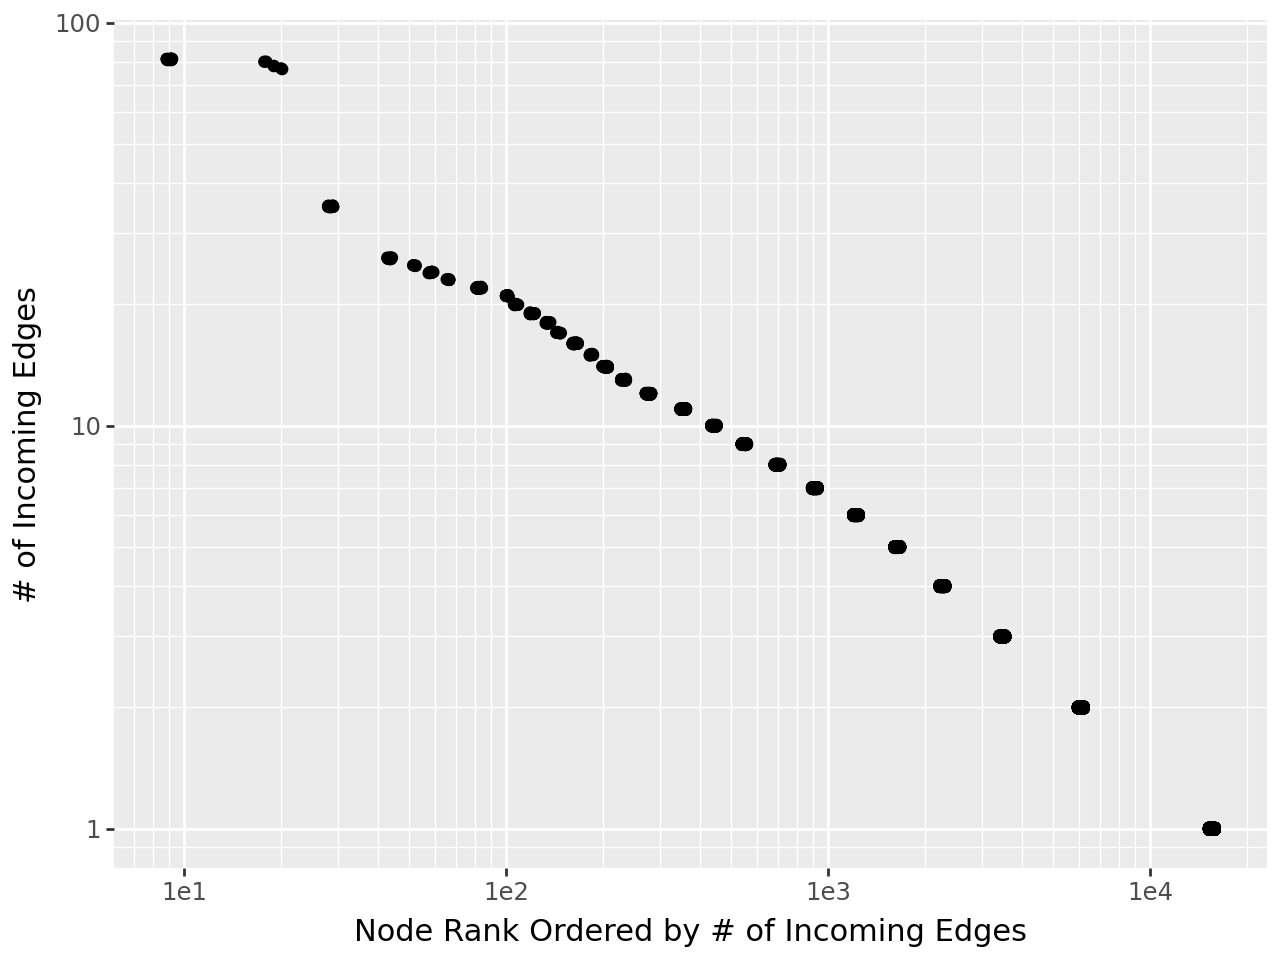

In [172]:
from plotnine import scale_x_log10, scale_y_log10, geom_jitter
df = node_df.with_columns(in_rank=pl.col('in_degree').rank(descending=True), out_rank = pl.col('out_degree').rank(descending=True))
(
    ggplot(df, aes(y='in_degree', x='in_rank')) 
    + geom_point() 
    + scale_x_log10() 
    + scale_y_log10() 
    + geom_jitter()
    + labs(x = 'Node Rank Ordered by # of Incoming Edges', y = '# of Incoming Edges')
)

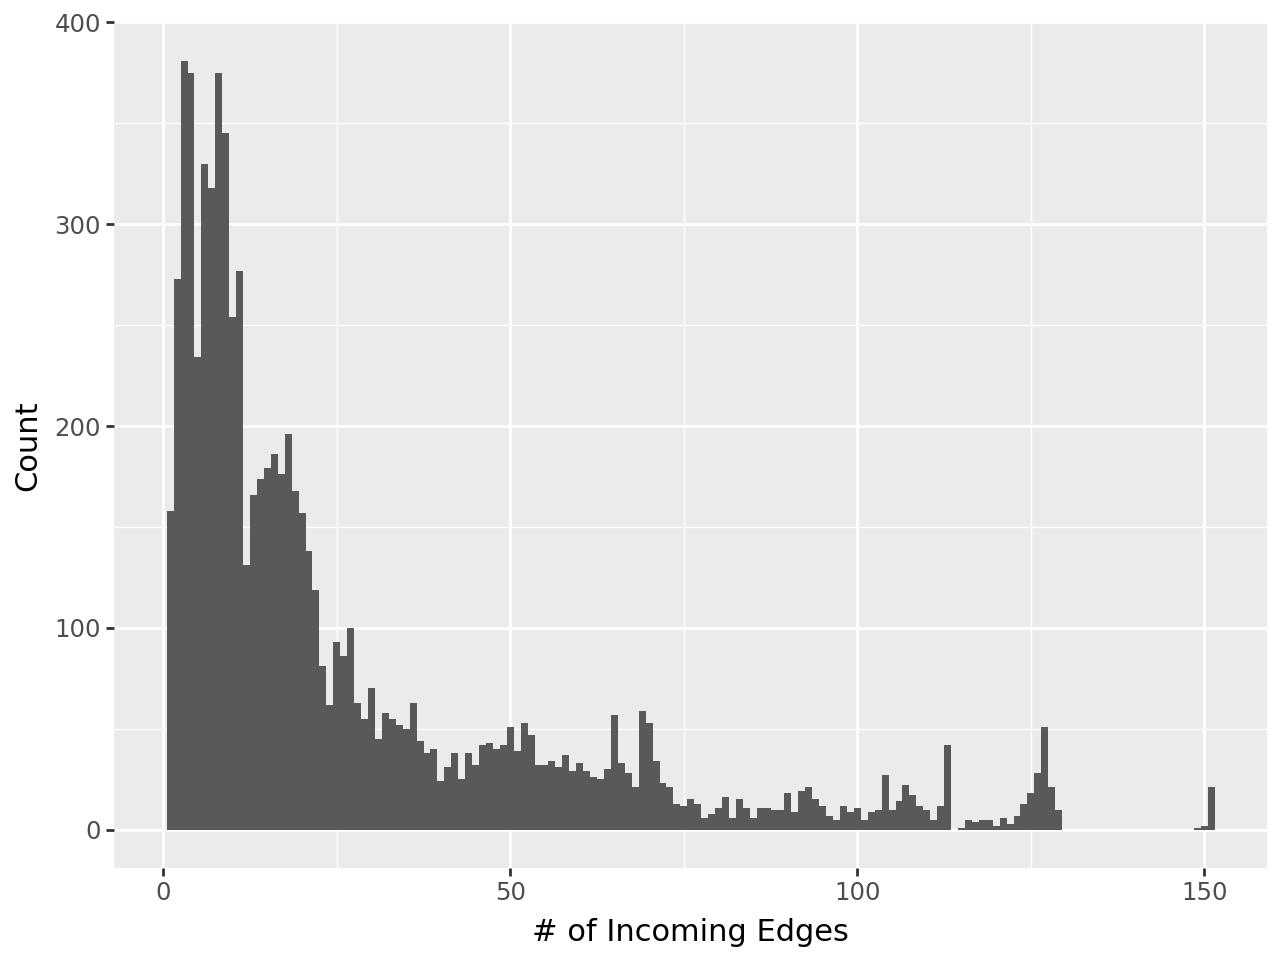

In [140]:
(
    ggplot(df, aes(x='in_degree') )
    + geom_histogram(binwidth=1) 
    + labs(y= 'Count', x = '# of Incoming Edges')
)

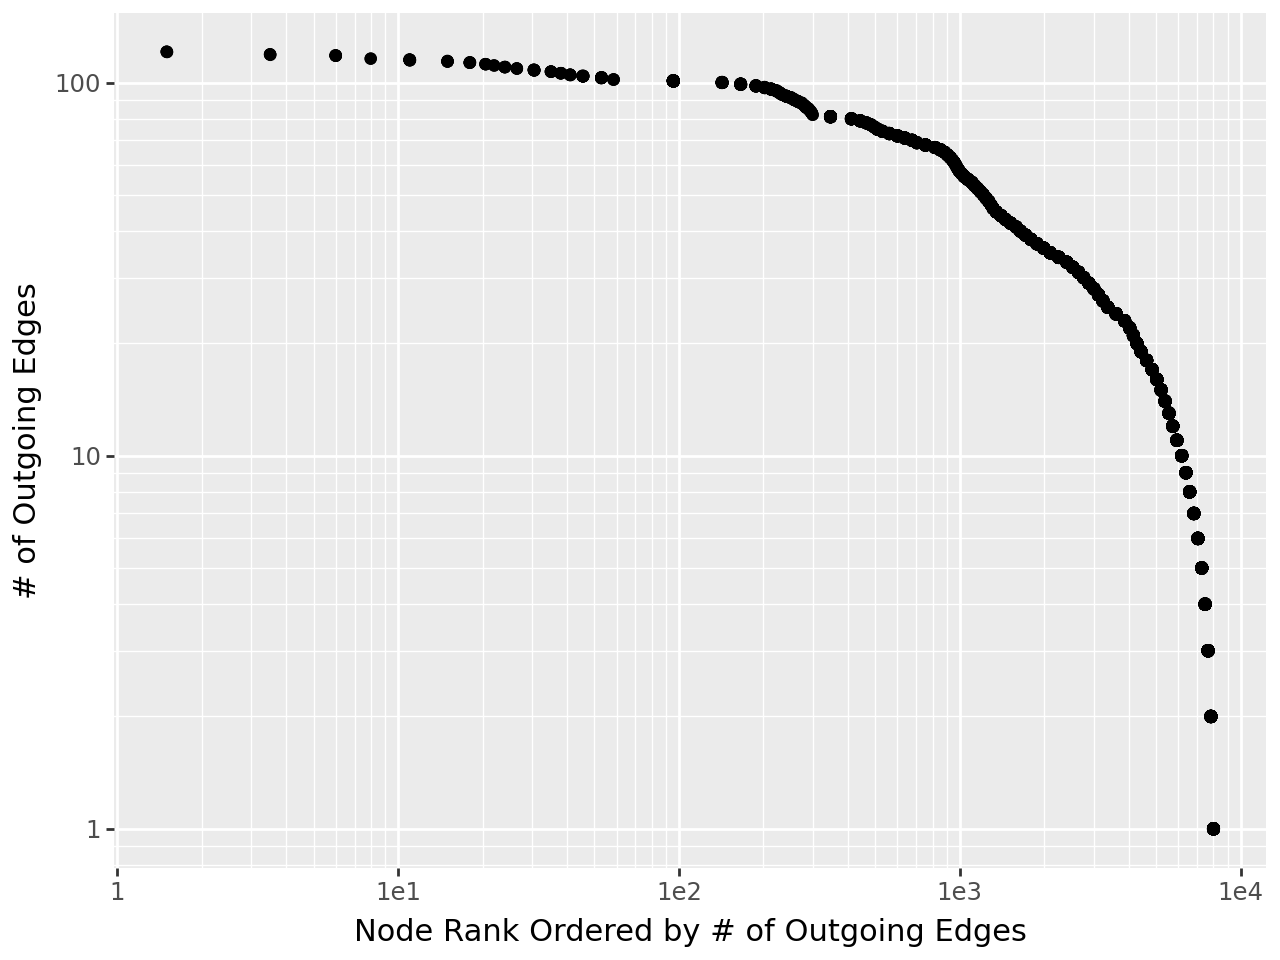

In [18]:

(
    ggplot(df, aes(y='out_degree', x='out_rank')) 
    + geom_point() 
    + scale_x_log10() 
    + scale_y_log10()
    + geom_jitter()
    + labs(x = 'Node Rank Ordered by # of Outgoing Edges', y = '# of Outgoing Edges')
)

/home/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


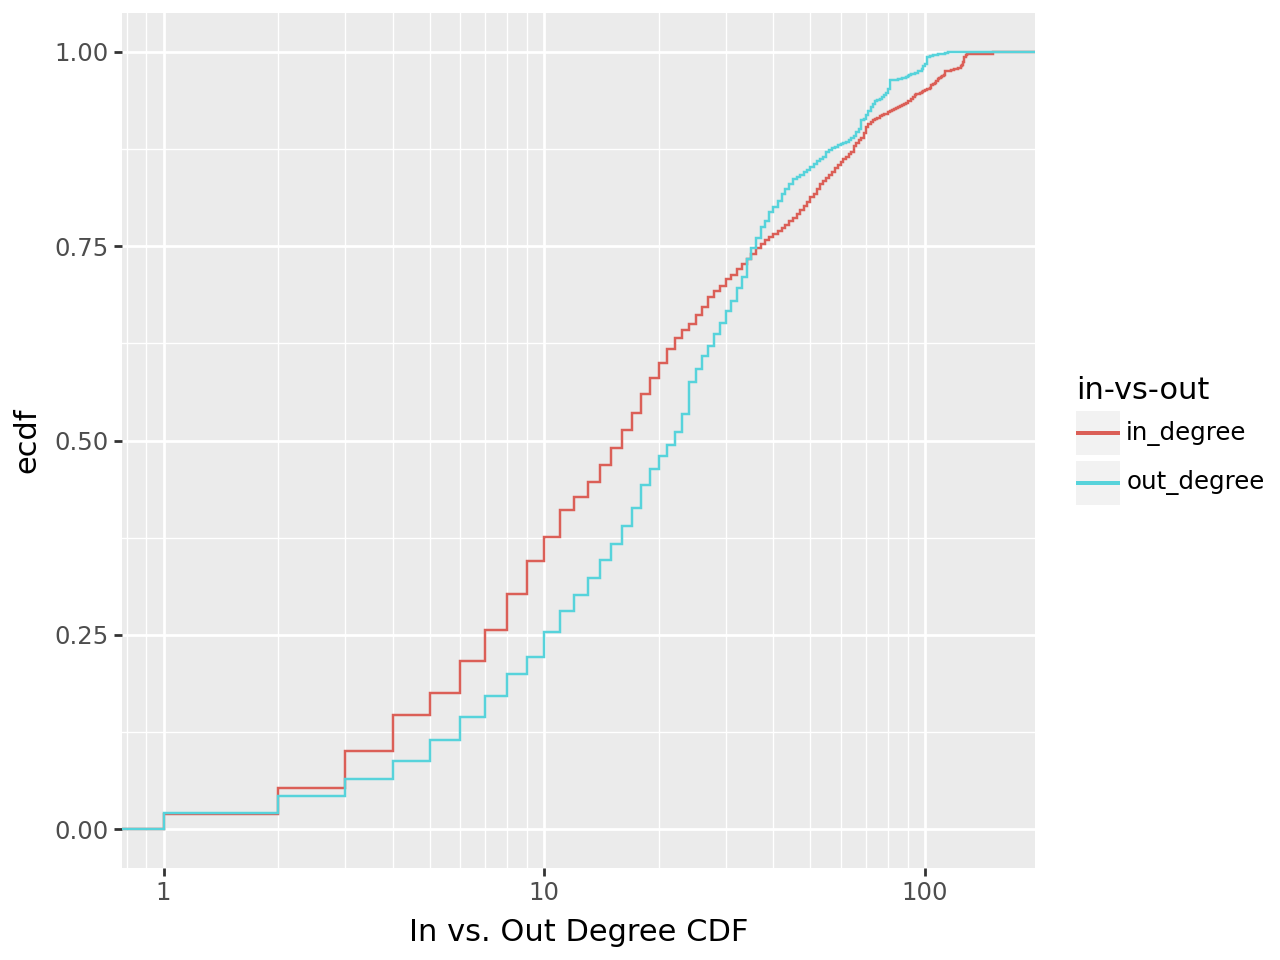

In [19]:
from plotnine import stat_ecdf

df = node_df.select(['in_degree', 'out_degree']).melt(variable_name='in-vs-out')


(
    ggplot(df, aes(x='value', color='in-vs-out'))
    + stat_ecdf(geom='step') 
    + scale_x_log10()
    + labs(x = 'In vs. Out Degree CDF')
)

In [208]:
import scipy
from scipy.sparse import csr_array
import cola


def calc_perron_vector(matrix, n_iter=5):
    vec = torch.ones((matrix.shape[0],), device=matrix.device)
    for _ in range(n_iter):
        new_vec = matrix @ vec
        new_vec /= new_vec.pow(2).sum().sqrt()
        vec = new_vec
    return vec
    

def symmetric_directed_laplacian(adjacency_matrix, device, n_iter=5):
    n = adjacency_matrix.shape[0]
    perron = cola.ops.Diagonal(calc_perron_vector(adjacency_matrix, n_iter=n_iter))
    perron.to(device)
    adj = cola.ops.Dense(adjacency_matrix)
    adj.to(device)
    Ident = cola.ops.I_like(perron)

    laplacian = (cola.sqrt(perron) @ adj @ cola.inv(cola.sqrt(perron)))
    laplacian +=  (cola.inv(cola.sqrt(perron)) @ adj.T @ cola.sqrt(perron))
    laplacian /= 2
                   
    return cola.SelfAdjoint(Ident - laplacian).to(device)

In [209]:
adj_mat = rx.adjacency_matrix(connected_subgraph, weight_fn= lambda x: float(x))
adj_mat /= adj_mat.sum(axis=1)[:, None]
adj_mat = torch.from_numpy(adj_mat).to(torch.float32)

In [217]:
device = torch.device('cuda:0')


In [223]:
laplacian = symmetric_directed_laplacian(adj_mat, torch.device('cpu'))

In [224]:
laplacian.device

device(type='cpu')

In [225]:
top_eigvals, top_eigvecs = cola.eig(laplacian, k=1000, which='LM')

In [226]:
top_eigvals

tensor([-1.3256e+00, -1.1960e+00, -1.1769e+00, -1.0923e+00, -1.0628e+00,
        -9.8013e-01, -9.7011e-01, -9.4488e-01, -8.3068e-01, -7.8363e-01,
        -7.6780e-01, -7.5499e-01, -7.1850e-01, -7.1562e-01, -7.1295e-01,
        -6.7451e-01, -6.7077e-01, -6.6835e-01, -6.4322e-01, -6.2221e-01,
        -6.0118e-01, -5.9743e-01, -5.8911e-01, -5.8305e-01, -5.6394e-01,
        -5.6185e-01, -5.5823e-01, -5.4937e-01, -5.4710e-01, -5.4120e-01,
        -5.2453e-01, -5.1121e-01, -5.0751e-01, -5.0576e-01, -4.9087e-01,
        -4.8858e-01, -4.8318e-01, -4.7717e-01, -4.7053e-01, -4.6634e-01,
        -4.6437e-01, -4.6180e-01, -4.4868e-01, -4.4403e-01, -4.3843e-01,
        -4.3422e-01, -4.2424e-01, -4.1147e-01, -4.0216e-01, -4.0020e-01,
        -3.9647e-01, -3.9402e-01, -3.9312e-01, -3.9290e-01, -3.9118e-01,
        -3.8806e-01, -3.8557e-01, -3.8221e-01, -3.7606e-01, -3.7304e-01,
        -3.7207e-01, -3.6496e-01, -3.5621e-01, -3.5204e-01, -3.4964e-01,
        -3.4301e-01, -3.4020e-01, -3.3488e-01, -3.3

In [103]:
from cola.linalg.eig.power_iteration import power_iteration

cuda = torch.device('cuda:0')
matrix = cola.ops.Dense(torch.from_numpy(adj_mat.T).to(torch.float32))
#arnoldi = cola.Arnoldi(start_vector=torch.ones((adj_mat.shape[0],)), max_iters=1000, tol=1e-04, pbar=True)
#power = power_iteration(max_iters=1000, tol=1.e-02, pbar=True)
"""
values, vectors = cola.eig(
    matrix,
    k=1,
    which='LM',
    alg=arnoldi
)
"""
v, eigmax, info = cola.PowerIteration(tol=1.0e-4)(matrix)

In [122]:
adj = torch.from_numpy(adj_mat.T).to(torch.float32)
p1 = adj @ torch.ones((adj_mat.shape[0],))
p1 /= p1.pow(2).sum().sqrt()
p1

tensor([0.0003, 0.0036, 0.0013,  ..., 0.0005, 0.0001, 0.0003])

In [123]:
p2 = (adj @ p1)
p2 /= p2.pow(2).sum().sqrt()

In [124]:
p3 = (adj @ p2)
p3 /= p3.pow(2).sum().sqrt()

In [134]:

def calc_perron_vector(matrix, n_iter=5):
    vec = torch.ones((matrix.shape[0],), device=matrix.device)
    for _ in range(n_iter):
        new_vec = matrix @ vec
        new_vec /= new_vec.pow(2).sum().sqrt()
        vec = new_vec
    return vec

In [135]:
perron = calc_perron_vector(adj)

In [136]:
perron

tensor([0.0003, 0.0012, 0.0009,  ..., 0.0008, 0.0002, 0.0009])

In [199]:
top_eigvals, top_eigvecs = cola.eig(laplacian, k=1000, which='LM')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!